In [1]:
import os
import numpy as np
import pandas as pd
from skimage import io
from tqdm import tqdm_notebook
from scipy import stats
from outliers import smirnov_grubbs as grubbs
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.getcwd()
if ROOT_DIR.endswith("notebooks"):
    # Go up one level to the repo root
    os.chdir(os.path.dirname(ROOT_DIR))
    
# Import unet library
from unet import utils

%matplotlib inline

# Quantification and statistics for Figure 5, S9, S10

__lab-inns1__ (Figure S9)

In [2]:
LAB = 'inns1'
MASK = 'cFOS'
MIN_PIXEL = 16
GROUPS = {'Ctrl' : 0, 'Ext' : 1}
OUTLIERS = ['1080']
FIG = 'S9'

__lab-inns2__ (Figure 10)

In [ ]:
LAB = 'inns2'
MASK = 'cFOS'
MIN_PIXEL = 60
GROUPS = {'Saline' : 0, 'L-DOPA responder' : 1, 'L-DOPA non-responder' : 2}
OUTLIERS = []
FIG = 'S10'

__lab-mue__ (Figure 5)

In [15]:
LAB = 'mue'
MIN_PIXEL = 30
MASK = 'cFOS'
GROUPS = {'Ext' : 0, 'Ret' : 1}
OUTLIERS = []
FIG = '5'

__lab-wue2__ (Figure 5)

In [10]:
LAB = 'wue2'
MIN_PIXEL = 112
MASK = 'Parv'
GROUPS = {'WT' : 0, 'KO' : 1}
MASK = 'Parv'
OUTLIERS = ['1699']
FIG = '5'

## Measure ROIs and area for all predictions

In [11]:
# Set paths and get model names
data_path = 'bioimage_data/lab-{}/images'.format(LAB)
mask_path = 'bioimage_data/lab-{}/labels'.format(LAB)
area_path = 'bioimage_data/lab-{}/regions'.format(LAB)
init_list = [x for x in next(os.walk(mask_path))[1] if not x.startswith('.')]
ens_list = [x for x in next(os.walk(os.path.join(mask_path,init_list[0])))[1] if not x.startswith('.')]

# Load images and areas
file_ids = [each.rsplit('.',1)[0] for each in os.listdir(data_path) if each.endswith('.tif')]
image_list = [io.imread(os.path.join(data_path, img_name), as_gray=True) for 
              img_name in [s + '.tif' for s in file_ids]]
area_list = [io.imread(os.path.join(area_path, img_name), as_gray=True) for 
              img_name in [s + '.tif' for s in file_ids]]

# Load and measure area
df_area_list = [utils.measure_rois(a, img, fid) for a, img, fid in zip(area_list, image_list, file_ids)]
df_area = pd.concat(df_area_list)
df_area.rename({'area': 'region_area'}, axis='columns', inplace=True)

# Loop over models
df_roi_list = []
for init in tqdm_notebook(init_list):
    for ens in tqdm_notebook(ens_list):
        fold_list = [x for x in next(os.walk(os.path.join(mask_path, init, ens)))[1] if not x.startswith('.')]
        model_list = [[x for x in next(os.walk(os.path.join(mask_path, init, ens, fold)))[1] if not x.startswith('.')][0] for fold in fold_list]
        
        for fold, model in zip(fold_list, model_list):
            model_path = os.path.join(mask_path, init, ens, fold, model)
            
            # Load masks
            mask_list = [io.imread(os.path.join(model_path, x), as_gray=True).astype('int') for x in [s + '_' + MASK + '.png' for s in file_ids]]
            
            # Cut irrelevant regions
            for msk, area in zip(mask_list, area_list):
                msk[area==0]=0
                
            # Measure ROIs
            df_list = [utils.measure_rois(msk, img, fid, min_pixel=MIN_PIXEL) for msk, img, fid in zip(mask_list, image_list, file_ids)]
            
            # Create output df
            df_tmp = pd.concat(df_list)
            df_tmp['init'] = init
            df_tmp['model'] = fold
            df_tmp['unet'] = model
            df_tmp['ens'] = ens
            df_roi_list += [df_tmp]
    
    # Concat dataframe
    df_roi = pd.concat(df_roi_list)
    df_roi = pd.merge(df_roi, df_area[['ID','region_area']], how='left', on='ID')

# Save results
df_roi.to_csv(os.path.join('source_data', 'fig_'+FIG, 'ROIs_'+LAB+'.csv'), index=False)

## Combine results with experimental data

In [12]:
# Get experimental image mapping
assignment = pd.read_excel('bioimage_data/image_mapping.xlsx')
df_zu = assignment[(assignment['name']=='lab-'+LAB)&
                    (assignment['experiment']=='Test')&
                    (assignment['training'].isna())].copy()
df_zu['Group'] = df_zu['condition'].transform(lambda x: GROUPS[x])

# Merge data
df_roi = pd.read_csv(os.path.join('source_data', 'fig_'+FIG, 'ROIs_'+LAB+'.csv'))
df = df_roi.groupby(['ens', 'unet', 'init', 'model', 'ID', 'region_area']).mean_intensity.agg(['mean', 'count'])
df = df.join(df_zu.set_index('ID')[['condition', 'Group', 'area']], how='left', on='ID')
df = df.reset_index(level=['region_area'])

# Normalize data
df['cfos_per_area'] = df['count']/df['region_area']
ctlr_norm = df[df.Group == 0].groupby(['ens', 'unet', 'model'])[['cfos_per_area', 'mean']].agg(np.mean)
df = df.join(ctlr_norm, rsuffix='_ctrl')
df['norm_cfos_per_area'] = df['cfos_per_area']/df['cfos_per_area_ctrl']
df['norm_mean_intensity'] = df['mean']/df['mean_ctrl']

# Save to Figure source data
df.to_csv('source_data/fig_{}/quantifications_{}.csv'.format(FIG, LAB))

## Outlier check

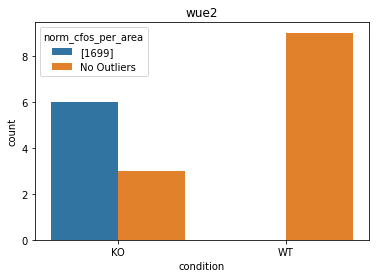

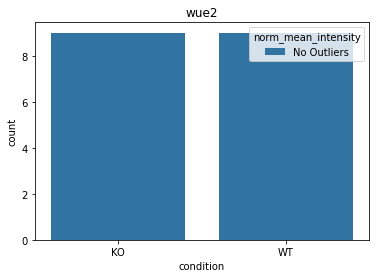

In [13]:
# Helper function
def get_outlier_names(x):
    out_ind = grubbs.two_sided_test_indices(x, alpha=0.05)
    if len(out_ind)>0:
        return str(x.iloc[out_ind].index.get_level_values('ID').values)
    else:
        return 'No Outliers'

# Find outliers in the most trustworthy models (consensus ensembles)
df_out = df.reset_index(level=['model', 'ens'])
df_out = (df_out[(df_out.model=='ensemble')&(df_out.ens.str.startswith('consensus'))]
          .groupby(['ens', 'unet', 'init', 'model', 'condition'])[['norm_cfos_per_area', 'norm_mean_intensity']]
          .agg(get_outlier_names).reset_index())
ax = sns.countplot(x="condition", hue='norm_cfos_per_area', data=df_out).set_title(LAB)
plt.show()
ax = sns.countplot(x="condition", hue='norm_mean_intensity', data=df_out).set_title(LAB)

## Compute statistics

In [14]:
# Remove Outliers
df = df[~df.index.isin(OUTLIERS, level=3)]

df_list = []
c_alpha = 0.05
c_alpha_list = [0.01, 0.001]
for key2, grp2 in tqdm_notebook(df.groupby(['ens', 'unet', 'model', 'area', 'init'])):

    for m in ['norm_cfos_per_area']:
        res_dict = {'subarea': [key2[3]], 'ens': [key2[0]], 'unet': [key2[1]],
                    'model': [key2[2]], 'init': [key2[4]], 'type': [m]}
        
        df_fil = grp2[~grp2[m].isna()]
        
        if all(df_fil.groupby('Group').size()>3):
            grp_data = [x[1] for x in df_fil.groupby('Group', sort=True)[m]]
            n_groups = len(grp_data)
            
            # Get Group Means
            grp_means = [x.mean() for x in grp_data]  
            for i, mean in enumerate(grp_means):
                res_dict['grp_mean_{}'.format(i+1)] = mean
                
            # Get Group Medians
            grp_medians = [x.median() for x in grp_data]  
            for i, med in enumerate(grp_medians):
                res_dict['grp_median_{}'.format(i+1)] = med
                
            # Get Group SD
            grp_std = [x.std() for x in grp_data]  
            for i, std in enumerate(grp_std):
                res_dict['grp_std_{}'.format(i+1)] = std
            
            # Perform the Shapiro-Wilk test for normality.
            grp_norms = [x[1] for x in map(stats.shapiro, grp_data)]
            
            #Check for equality of variances
            if len(grp_data)>2:
                _, levene = stats.levene(*grp_data, center = 'mean')
            else:
                _, levene = stats.levene(*grp_data, center = 'median')
            
            # Anova possible?
            anova = True if all(np.array([*grp_norms,levene])> 0.05) else False
            res_dict['anova_ok'] = [anova]
        
            # Only 3 groups tests
            if n_groups==3: 
                
                # kruskal-wallis anova all groups
                H, kwa_p_value = stats.kruskal(*grp_data)
                N = len(df_fil)
                
                kwa_eta_squared = (H - n_groups + 1)/(N-n_groups) # http://tss.awf.poznan.pl/files/3_Trends_Vol21_2014__no1_20.pdf
                # kwa_eta_squared = ((H / (n_groups-1)) * (n_groups-1)) / ((H / (n_groups-1)) * (n_groups-1) + (N-n_groups)) 
                #For references, see: https://www.researchgate.net/post/Anyone_know_how_to_calculate_eta_squared_for_a_Kruskal-Wallis_analysis
                res_dict['U_kwa_all'] = [H]
                res_dict['eta^2_kwa_all'] = [kwa_eta_squared]
                res_dict['p_kwa_all'] = [kwa_p_value]
                res_dict['kwa_all'] = 1 if kwa_p_value<0.05 else 0
                # Critical Value
                p = 1-c_alpha
                ddof = n_groups-1
                H_c = stats.chi2.ppf(p, ddof) 
                kwa_eta_squared_c = (H_c- n_groups + 1)/(N-n_groups) 
                res_dict['c_kwa_all'] = [kwa_eta_squared_c]

            # Pairwise tests
            for i,j in itertools.combinations(range(len(grp_data)), 2):
                k, l = i+1, j+1
                
                # Pairwise mannwhitneyu tests
                U, mwu_p_value = stats.mannwhitneyu(grp_data[i],grp_data[j], alternative = 'two-sided')
                n_1 = grp_data[i].count()
                n_2 = grp_data[j].count()
                N = n_1 + n_2
                mwu_eta_squared = ((U - (n_1*n_2/2)) / np.sqrt((n_1*n_2*(n_1+n_2+1))/12) / np.sqrt(n_1+n_2))**2
                # according to http://www.statisticslectures.com/topics/mannwhitneyu/ & cross-checked with Origin & psychometrica
                res_dict['U_mwu{}_vs_{}'.format(k,l)] = [U]
                res_dict['eta^2_mwu{}_vs_{}'.format(k,l)] = [mwu_eta_squared]
                res_dict['p_mwu{}_vs_{}'.format(k,l)] = [mwu_p_value]
                # Critical Value @0.05
                p = 1-c_alpha if n_groups==2 else 1-(c_alpha/n_groups)
                U_c = stats.chi2.ppf(p, 1)
                mwu_eta_squared_c = U_c/N 
                # Eta squared can be calculated as η²=r²=chi²/N. Note that the Kruskal-Wallis H test statistic is approximately chi²-distributed.
                res_dict['c_mwu{}_vs_{}'.format(k,l)] = [mwu_eta_squared_c]
                # Other Critical Valus
                for c_al in c_alpha_list:
                    p_al = 1-c_al if n_groups==2 else 1-(c_al/n_groups)
                    U_c_al = stats.chi2.ppf(p_al, 1)
                    mwu_eta_squared_c_al = U_c_al/N 
                    res_dict['c{}_mwu{}_vs_{}'.format(c_al, k,l)] = [mwu_eta_squared_c_al]
                
                # Direction check  
                mwu_i_vs_j = 0  
                if grp_medians[i] != grp_medians[j]:
                    if all((n_groups==2, mwu_p_value <= c_alpha)) ^ all((n_groups>2, mwu_p_value <= c_alpha/n_groups)):
                        mwu_i_vs_j = k if (grp_medians[i] > grp_medians[j]) else l
                res_dict['mwu{}_vs_{}'.format(k,l)] = [mwu_i_vs_j] 
                
                 
        df_list += [pd.DataFrame(res_dict)]

df_final = pd.concat(df_list)

# Save to Figure source data
df_final.to_csv('source_data/fig_{}/stat_results_quantifications_{}.csv'.format(FIG, LAB), index=False)